# Apolloscape Dataset Reader: Localization Task

This is an example of using Apolloscape dataset for route visualization and simple graphs/videos.

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import HTML

import torch
from datasets.apolloscape import Apolloscape
from utils.common import draw_poses, calc_poses_params
from utils.common import draw_record, make_video
import numpy as np
from torchvision import transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import os

%matplotlib inline
plt.ion()



### Setup the Apolloscape root directory

`APOLLO_PATH` is an location with unpacked Apolloscape datasets, e.g. `$APOLLO_PATH/road02_seg` or `$APOLLO_PATH/zpark`. Download data from [Apolloscape page](http://apolloscape.auto/scene.html) and unpack. Let's assume that you've linked this folder to `./data/apolloscape`.

In [2]:
APOLLO_PATH = "./data/apolloscape"

### Create dataset object

In [9]:
# Resize data before using
transform = transforms.Compose([transforms.Resize(250)])

# record_name = "Record029"
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road02_seg", transform=transform, record=record_name)

# record_name = "Record018" # Record018 - example with a turn
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road03_seg", transform=transform, record=record_name)

# record_name = "Record012"
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road04_seg", transform=transform, record=record_name)

# record_name = "Record008"
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
#                              transform=transform, record=record_name)

# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
#                              transform=transform, train=True)

stereo = False

record_name = "Record013"
apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, train=False, record=record_name, pose_format='quat',
                             normalize_poses=False, cache_transform=True, stereo=stereo)


print(apollo_dataset)



Dataset: Apolloscape
    Road: zpark-sample
    Record: Record013
    Train: False
    Normalize Poses: False
    Stereo: False
    Length: 240 of 756
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']



## Show All Records Counts

In [10]:
# Show records with numbers of data points
recs_num = apollo_dataset.get_records_counts()
recs_num = sorted(recs_num.items(), key=lambda kv: kv[1], reverse=True)
print("Records:")
print("\n".join(["\t{} - {}".format(r[0], r[1]) for r in recs_num ]))

Records:
	Record012 - 242
	Record013 - 240
	Record011 - 174
	Record014 - 100
	Record002 - 0
	Record007 - 0
	Record006 - 0
	Record003 - 0
	Record008 - 0
	Record010 - 0
	Record009 - 0
	Record001 - 0
	Record004 - 0


## Show current Record on a plot

In [14]:

# Draw path of the current record with a sampled datapoint
# draw_record(apollo_dataset)
# plt.show()
    
# Draw all records
for record in apollo_dataset.records_list:
    print('hello')
    draw_record(apollo_dataset, record)
    



hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello


/home/pavlo/code/apolloscape-loc/utils/common.py:86: UserWarning: This method supports only stereo mode. Other: NOT IMPLEMENTED
  warnings.warn('This method supports only stereo mode. Other: NOT IMPLEMENTED')


In [ ]:
# apollo_dataset.record = None
# for i in range(len(apollo_dataset)):
#     images, poses = apollo_dataset[i]
#     print('i = {}'.format(i))
        


## Generate video for current record

In [6]:
# Generate videos

# Generate and save video for the record
outfile = "./output_data/videos/video_{}_{}.mp4".format(apollo_dataset.road, apollo_dataset.record)
make_video(apollo_dataset, outfile=outfile)


# Create all available datasets
# road04_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road04_seg",transform=transform)
# road03_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road03_seg",transform=transform)
# road02_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road02_seg", transform=transform)
zpark_sample_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample", transform=transform)

# datasets = [road04_dataset, road03_dataset, road02_dataset, zpark_sample_dataset]
datasets = [zpark_sample_dataset]
# datasets = [road04_dataset]

# Generate videos for all records in all datasets
# video will be stored in `./output_data/videos` location
# for dataset in datasets:
#     for record in dataset.records_list:
#         print('dataset = {}, record = {}'.format(dataset.road, record))
#         make_video(dataset, record=record)



  1%|          | 1/120 [00:00<00:12,  9.34it/s]

Saving video to: ./output_data/videos/video_zpark-sample_Record013.mp4


100%|██████████| 120/120 [00:09<00:00, 12.29it/s]


Video saved successfully!


In [7]:
# View saved video
HTML("""
<p>Playing <strong>{0}</strong></p>
<video width="640" height="480" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(outfile))

## Draw all Records of all Datasets

Showing all routes in one graph with projections. Adjust available `datasets` in first lines.

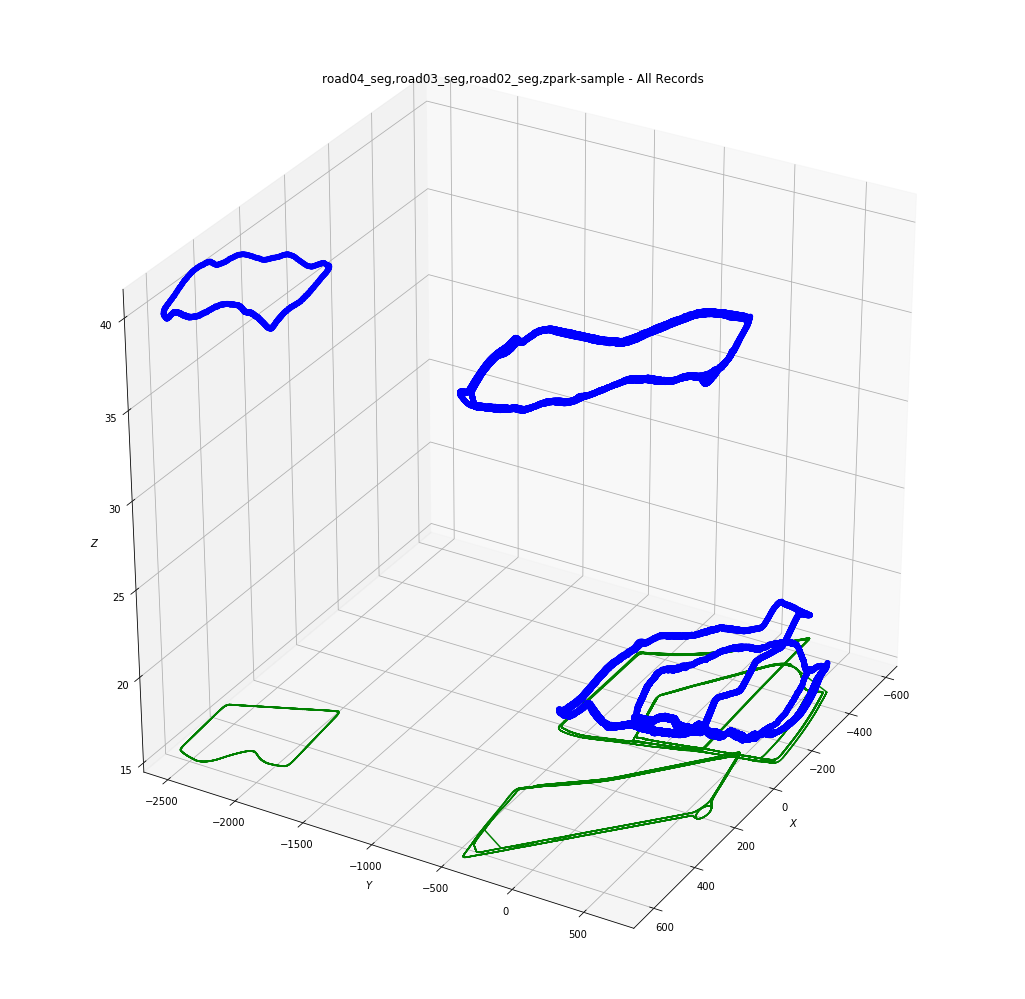

In [8]:
# Draw all records of all datasets on one chart

road04_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road04_seg",transform=transform)
road03_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road03_seg",transform=transform)
road02_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road02_seg", transform=transform)
zpark_sample_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample", transform=transform)

datasets = [road04_dataset, road03_dataset, road02_dataset, zpark_sample_dataset] # , zpark_sample_dataset


# Collect all poses from all datasets
all_poses = []
for dataset in datasets:
    ps = dataset.d_poses
    all_poses.extend(ps)
    

# Calculate poses parameters for all records
# all_poses = np.concatenate((poses1, poses2))
p_min, p_max, p_mean, p_std = calc_poses_params(all_poses)
# print("min = {}".format(p_min))
# print("max = {}".format(p_max))
# print("mean = {}".format(p_mean))
# print("std = {}".format(p_std))



fig = plt.figure(figsize=(18, 18))

ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(30, 30)
# ax.set_aspect('equal')

ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')


ax.set_title("{} - All Records".format(",".join([d.road for d in datasets])))

# Set plot limits acc to selected poses
ax.set_xlim(int(p_min[0]), int(p_max[0]) + 1)
ax.set_ylim(int(p_min[1]), int(p_max[1]) + 1)
ax.set_zlim(int(p_min[2]), int(p_max[2]) + 1)


for dataset in datasets:
    for record in dataset.records_list:
        dataset.record = record
        
#         data_array_rec = dataset.data_array
#         ps1 = data_array_rec[:, 1]
#         ps2 = data_array_rec[:, 3]
#         mid_poses = 0.5 * (ps1 + ps2)
        
        poses = dataset.d_poses_rec

        # Show all poses for selected record
        draw_poses(ax, poses, proj=True, proj_z=int(p_min[2]), pose_format=dataset.pose_format)
    
    
plt.show()

    